# C-Mechanism 
### Based on D'Ayala and Speranza, 2002/2003

Authors: Aline Bönzli and Caroline Heitmann, EESD EPFL

This notebok was created during our work on our Master Theses at the EESD lab at EPFL and serves the visualization of an out-of-plane (OOP) mechanism of an unreinforced masonry (URM) wall. All calculations should be vefified by the user and the authors do not take any responsibility for application and interpretation of the results of this notebook. 

## Introduction

This notebook can be used to calculate the pushover curve for a basic out-of-plane C-mechanisms of a masonry structure subject to seismic action. First, the geometric and material characteristics will be defined, then depending on these inputs, the displacement capacity for out-of-plane accelerations will be returned.

This is a generic case of a bell tower. To apply it to a specific building, make sure to adapt the code where needed.

In [1]:
### NOTHING TO BE CHANGED
# Import the basic packages for the notebook
import numpy as np # Numerical library
import pandas as pd # Data analysis library
import matplotlib.pyplot as plt # Plotting library
import matplotlib.ticker as maticker #

## 1. Define wall geometry

This code computes the OOP mechanism referred to as C in D'Ayala (2003). This mechanism involves the rotation of two connected walls (i.e. a corner) around a horizontal hinge. The angles of crack are the result of the minimization procedure for in-plane failure.

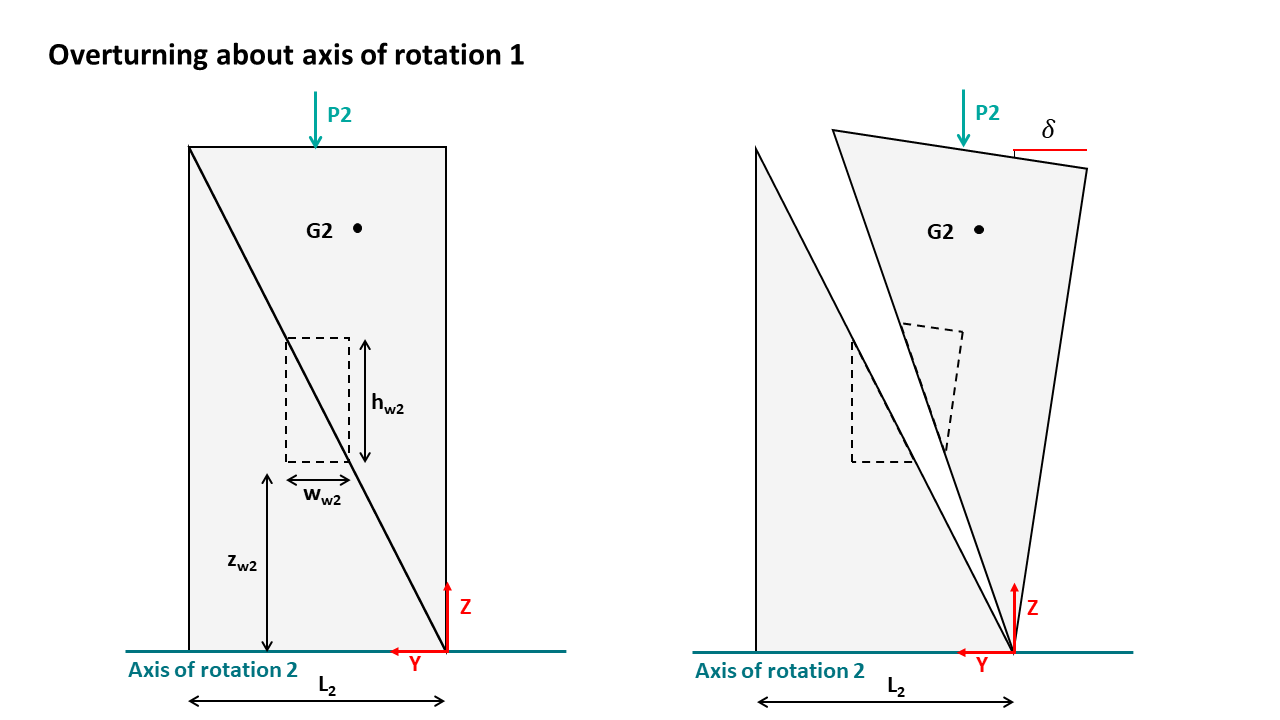

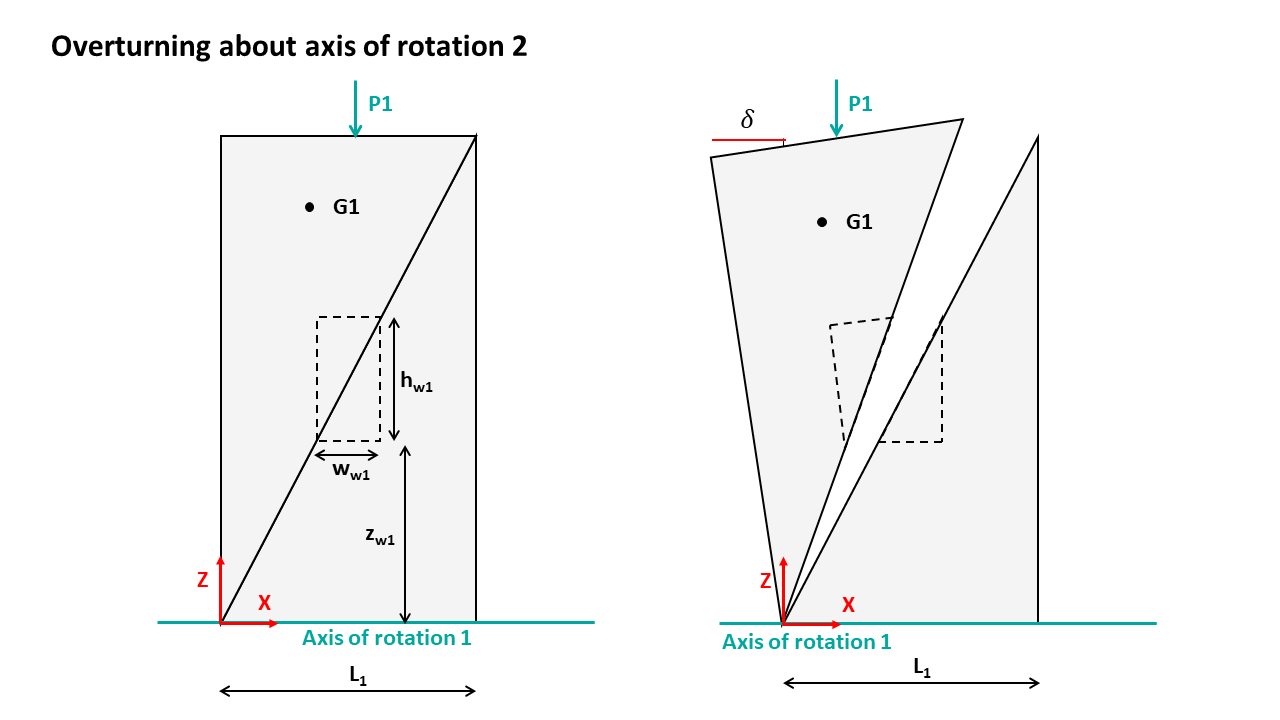

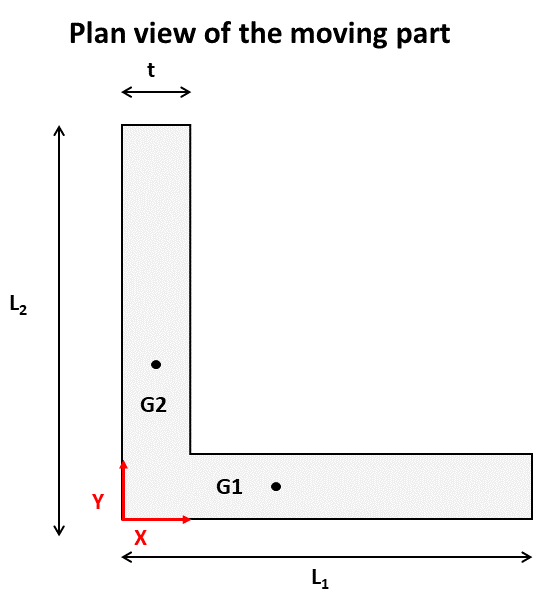

In [2]:
### NOTHING TO BE CHANGED
from IPython.display import Image, display
display(Image(filename='C_Mec_1.PNG'))
display(Image(filename='C_Mec_2.PNG'))
display(Image(filename='C_Mec_3.PNG'))

This block is used to define the geometry of the wall and the windows within. Note that the geometry for this particular mechanism has the potential to be quite complex. As a result, this notebook computes a generalized triangular shape with the optional inclusion of a window. The crack is approximated to run through half of the (rectangular) window.

In [3]:
## Wall geometry
H = 14.0            # Total height of wall [m]
L1 = 6.0            # Length of wall, x-direction [m]
L2 = 6.5            # Length of wall, y-direction [m]
t = 1.0             # Thickness of wall [m]

## Window geometry
h_w1 = 0.6          # Height of window on length L1 [m]
w_w1 = 0.5          # Width of window on length L1[m]
z_w1 = 8.0          # Vertical distance from bottom of wall to bottom lefthand corner of window on length L1 [m]
                    # (i.e. the z-coordinate of the window's left bottom corner)
h_w2 = 0            # Height of window on length L2 [m]
w_w2 = 0            # Width of window on length L2[m]
z_w2 = 0            # Vertical distance from bottom of wall to bottom lefthand corner of window on length L2 [m]
                    # (i.e. the z-coordinate of the window's left bottom corner)

### 2. Define material properties

In this chapter, the material properties of the wall and its connecting slab(s) are defined.

In [4]:
rho_m = 18000 # Density of the masonry [N/m^3]
mu_f = 0.3    # Friction coefficient between slab and masonry wall

### 3. Define acting loads

In this paragraph, the loads acting on the wall are defined. Since the mechanism is located in the bell tower at the top of the structure, the only loads to consider are axial loads coming from the roof. The load is defined as a distributed load over the length of each wall section, which will act at the midpoint of the wall length.

In [5]:
P1 = 50000                # Axial load acting on wall length L1 [N]
P2 = 55000                # Axial load acting on wall length L2 [N]

### 4. Calculate the overturning moment

The following block calculates the pushover curve for the given case. The only lines to pay attention to are those that define the geometry of the bell tower. As mentioned above, the current notebook evaluates a bell tower with one window on the front facade and no windows on the side facade. Change the functions  for example, to consider additional windows or crack eccentricity). The current conception involves one window in the leftmost facade and no windows in the rightmost facade. 

After applying the lateral load, the wall begins to rotate around a pivot point. Considering the deformed state (while assuming small deformations), the static equilibrium is calculated for a range of displacements to capture the whole response.

In [6]:
## Specify location of windows
# use "yes" if there is (one) window present
# use "no" if no windows are present

facade_left = "yes"
facade_right = "no"

In [7]:
### NOTHING TO BE CHANGED
## Define the calculation of the center of gravity for a bell tower block with a window
# local coordinate system for x-, y-, and z-directions
def cog_fun_win(t,Lx,H,w_w,h_w,z_w):
    Ab = (Lx*H/2)-(w_w*h_w/2)                                  # Area of block [m^2]
    vol = t*Ab                                                 # Volume of block [m^3]
    COG_x = ((Lx/3)*(Lx*H/2)-(Lx/2)*(w_w*h_w/2))/Ab            # x-centroid [m]
    COG_y = t/2                                                # y-centroid [m]
    COG_z = ((2*H/3)*(Lx*H/2)-(h_w/2+z_w)*(w_w*h_w/2))/Ab      # z-centroid [m]

    return COG_x,COG_y,COG_z,vol

## Define the calculation of the center of gravity for a bell tower block with no windows
#  local coordinate system for x-, y-, and z-directions
def cog_fun(t,Lx,H):
    Ab = Lx*H/2                                                # Area of block [m^2]
    vol = t*Ab                                                 # Volume of block [m^3]
    COG_x = Lx/3                                               # x-centroid [m]
    COG_y = t/2                                                # y-centroid [m]
    COG_z = 2*H/3                                              # z-centroid [m]

    return COG_x,COG_y,COG_z,vol

## Calculate COGs according to presence of windows
def calc_cog(facade_ind,t,Lx,H,w_w,h_w,z_w):
    if facade_ind == "yes":
        [COG_x,COG_y,COG_z,vol] = cog_fun_win(t,Lx,H,w_w,h_w,z_w)
    else:
        [COG_x,COG_y,COG_z,vol] = cog_fun(t,Lx,H)
    
    return COG_x,COG_y,COG_z,vol

## Calculate mass of each block (left = block 1, right = block 2)
[xbar1,ybar1,zbar1,vol1] = calc_cog(facade_left,t,L1,H,w_w1,h_w1,z_w1)
[xbar2,ybar2,zbar2,vol2] = calc_cog(facade_right,t,L2,H,w_w2,h_w2,z_w2)
m1 = rho_m*vol1
m2 = rho_m*vol2

# organize properties
h = np.array([[zbar1,zbar2]])        # Height (i.e. y-centroid) of each rigid block [m]
m = np.array([[m1,m2]])              # Load of each rigid block [kg]

## Derive other loads acting on the blocks
Ff1 = mu_f*P1                        # Friction force from roof acting on top of wall length L1 [N]
Ff2 = mu_f*P2                        # Friction force from roof acting on top of wall length L2 [N]

G1 = m1                              # Gravity load of block 1 (self-weight) [N]
G2 = m2                              # Gravity load of block 2 (self-weight) [N]

## Consider rotation about the x-axis – determine the lateral force necessary for overturning
def Q_fun_x(delta,Ff,H,P1,P2,G1,G2,L1,t,xbar1,xbar2,zbar1,zbar2): 
    # all forces contribute
    if delta<t/2:
        Q_equ=2*(Ff*H+P1*(L1/2-delta)+P2*(t/2-delta)+G1*(ybar1-delta*zbar1/H)+G2*(ybar2-delta*zbar2/H))/(zbar1+zbar2)
    # connection with out-of-plane wall is lost
    elif delta>=t/2 and delta<L1/2:
        Q_equ=2*(Ff*H+P1*(L1/2-delta)+G1*(ybar1-delta*zbar1/H)+G2*(ybar2-delta*zbar2/H))/(zbar1+zbar2) 
    # connection with in-plane wall is lost
    elif delta>=L1/2:
        Q_equ=2*((G1*(ybar1-delta*zbar1/H))+(G2*(ybar2-delta*zbar2/H)))/(zbar1+zbar2) 

    return Q_equ

# determine the horizontal multiplier 
def a_fun_x(Q_x,H,G1,G2): 
    alpha_equ = Q_x*H/(G1+G2)
    
    return alpha_equ

## Consider rotation about the y-axis – determine the lateral force necessary for overturning
def Q_fun_y(delta,Ff,H,P1,P2,G1,G2,L2,t,xbar1,xbar2,zbar1,zbar2): 
    # all forces contribute
    if delta<t/2:
        Q_equ=2*(Ff*H+P2*(L2/2-delta)+P1*(t/2-delta)+G1*(xbar1-delta*zbar1/H)+G2*(xbar2-delta*zbar2/H))/(zbar1+zbar2)
    # connection with out-of-plane wall is lost
    elif delta>=t/2 and delta<L2/2:
        Q_equ=2*(Ff*H+P2*(L2/2-delta)+G1*(xbar1-delta*zbar1/H)+G2*(xbar2-delta*zbar2/H))/(zbar1+zbar2)
    # connection with in-plane wall is lost
    elif delta>=L2/2:
        Q_equ=2*(G1*(xbar1-delta*zbar1/H)+G2*(xbar2-delta*zbar2/H))/(zbar1+zbar2) 
    
    return Q_equ

# determine the horizontal multiplier
def a_fun_y(Q_y,H,G1,G2): 
    alpha_equ = Q_y*H/(G1+G2)
    
    return alpha_equ

## Calculate the displacement at the top of the blocks – here, it is calculated for rotation around the 
## y-axis, since this is the controlling case
def delta_fun_y(Qs,Ff,H,P1,P2,G1,G2,L2,t,xbar1,xbar2,zbar1,zbar2): 
    del_equ=((Ff*H)+(P2*L2/2)+(P1*t/2)+(G1*xbar1)+(G2*xbar2)-(0.5*Qs*(zbar1+zbar2)))/(P1+P2+(G1*zbar1/H)+(G2*zbar2/H))
    
    return del_equ

Text(0.5, 1.0, 'Force-Displacement')

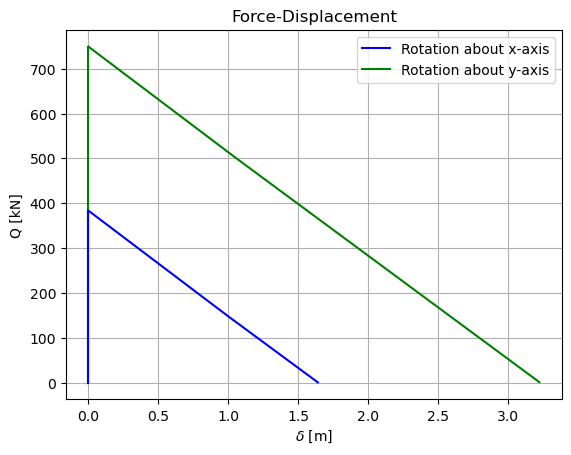

In [8]:
### NOTHING TO BE CHANGED
# plot force-displacement relationship
delta_vals = np.linspace(0,H,1000)
f_vals_x = np.zeros((1000,1))
f_vals_y = np.zeros((1000,1))

for i in range(1000):
    f_vals_x[i] = Q_fun_x(delta_vals[i],Ff2,H,P1,P2,G1,G2,L1,t,ybar1,ybar2,zbar1,zbar2)
    f_vals_y[i] = Q_fun_y(delta_vals[i],Ff1,H,P1,P2,G1,G2,L2,t,xbar1,xbar2,zbar1,zbar2)

# Transformation to only display values up to failure
f_vals_x = f_vals_x[f_vals_x>=0]
delta_vals_x = delta_vals[: np.size(f_vals_x)]
f_vals_y = f_vals_y[f_vals_y>=0]
delta_vals_y = delta_vals[: np.size(f_vals_y)]
delta_min=min(delta_vals_x[-1],delta_vals_y[-1])
    
plt.figure()
plt.grid()
plt.plot(delta_vals_x,f_vals_x/1000,color='blue',label='Rotation about x-axis')
plt.plot(delta_vals_y,f_vals_y/1000,color='green',label='Rotation about y-axis')
plt.plot([0,0],[0,f_vals_y[0]/1000],color='green')
plt.plot([0,0],[0,f_vals_x[0]/1000],color='blue')

plt.legend()
plt.xlabel('$\delta$ [m]')
plt.ylabel('Q [kN]')
plt.title('Force-Displacement')

Text(0.5, 1.0, 'a - Displacement')

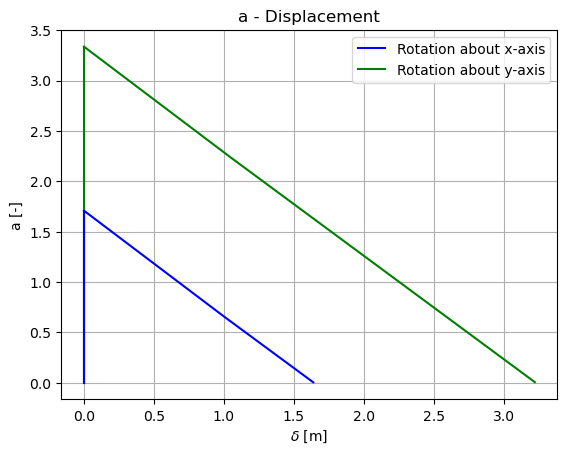

In [9]:
### NOTHING TO BE CHANGED
# plot relationship between load factor and displacement
a_vals_x = np.zeros((1000,1))
a_vals_y = np.zeros((1000,1))

for i in range(1000):
    Q_x = Q_fun_x(delta_vals[i],Ff2,H,P1,P2,G1,G2,L1,t,ybar1,ybar2,zbar1,zbar2)
    Q_y = Q_fun_y(delta_vals[i],Ff1,H,P1,P2,G1,G2,L2,t,xbar1,xbar2,zbar1,zbar2)
    a_vals_x[i] = a_fun_x(Q_x,H,G1,G2)
    a_vals_y[i] = a_fun_y(Q_y,H,G1,G2)

# Transformation to only display values up to failure 
a_vals_x = a_vals_x[a_vals_x>=0]
delta_vals_x = delta_vals[: np.size(a_vals_x)]
a_vals_y = a_vals_y[a_vals_y>=0]
delta_vals_y = delta_vals[: np.size(f_vals_y)]

plt.figure()
plt.grid()
plt.plot(delta_vals_x,a_vals_x,color='blue',label='Rotation about x-axis')
plt.plot(delta_vals_y,a_vals_y,color='green',label='Rotation about y-axis')
plt.plot([0,0],[0,a_vals_y[0]],color='green')
plt.plot([0,0],[0,a_vals_x[0]],color='blue')
plt.legend()

plt.xlabel('$\delta$ [m]')
plt.ylabel('a [-]')
plt.title('a - Displacement')

### 5. Computation of capacity curve

This section will allow you to analyze the structural response in the context of the seismic spectrum. The goal is to compare the capacity curve to the response spectrum, which will allow the behaviour of the wall to be interpreted (e.g., indicating whether it would meet its design requirements).

The main input is the spectral acceleration (for a 475-year return period) for the wall in its given location, as well as its period. For users of the Swiss code, SIA 261 chapter 16.2.1.2 provides the horizontal soil acceleration for each seismic zone; otherwise it can be found in the relevant National Annex of the Eurocode. The period can be computed by calculating the mass and total stiffness (dependent on both flexural and shear stiffness), through an approximation such as the one found in SIA 261 16.5.2.3., or a modal analysis.

As stated above, this section will provide an interpretation of the wall's behavior according to a trilinear force-displacement model. These model utilizes three points: two displacement parameters, $\delta_1$ and $\delta_2$, and the maximum displacement capacity, $\delta_0$. Below, the trilinear approximation as determined by Griffith et al. (2003) is plotted alongside the bilinear relationship and the real semi-rigid nonlinear relationship. According to Griffith et al. (2003), these coefficients depend on the material quality. Note that for this notebook, $\delta_u$ is approximated to be equivalent to $\delta_0$ in this code.

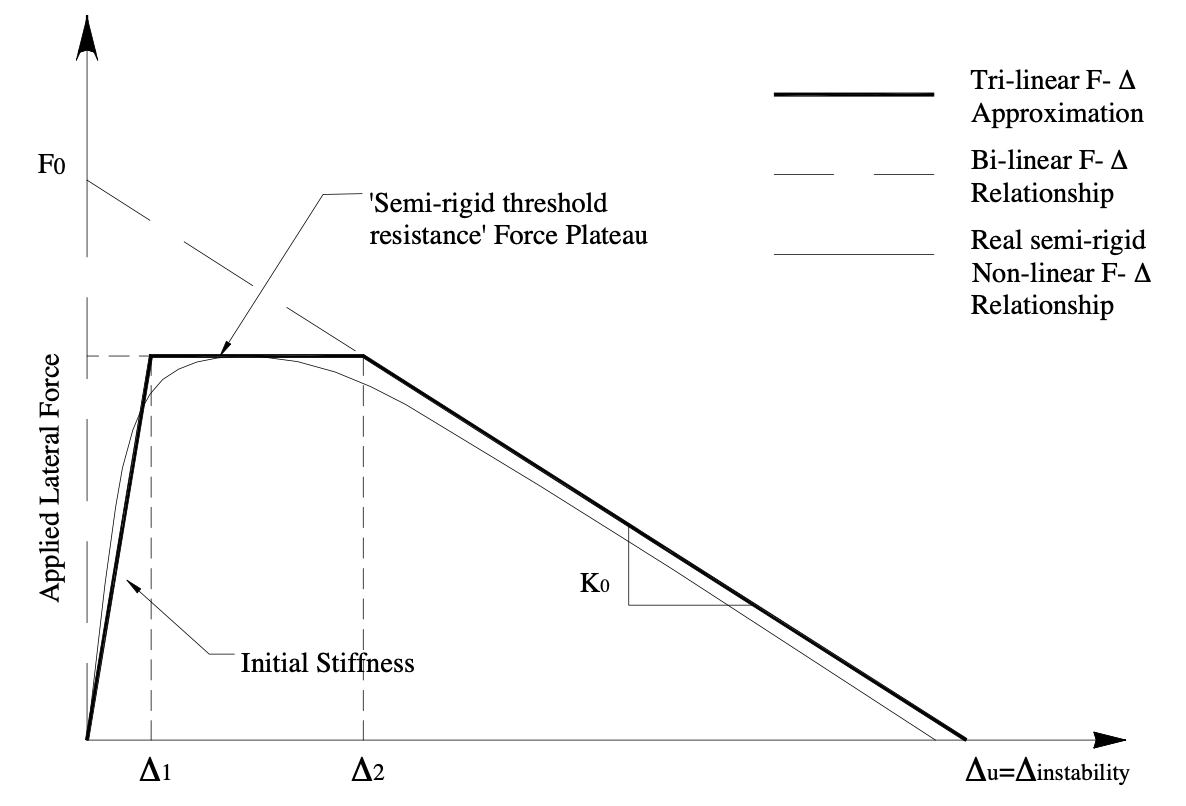

In [10]:
display(Image(filename='Griffith_Trilinear.png'))

This block is used to define the horizontal reference acceleration that can be found on seismic maps, sh as the one provided in the appendix of SIA 261 or the natinal annexes of the Eurocode.

In [11]:
agr = 0.195           # Horizontal soil acceleration [g]

# Choose the coefficients for the trilinear model per Griffith et al. (2003)
d1 = 0.125            # Range from 0.05 to 0.20
d2 = 0.375            # Range from 0.25 to 0.50

Response spectra are defined for single degree of freedom (DOF) systems, however, the C mechanism involves several rigid blocks and hence several DOFs. In order to compare the capacity curve to the spectrum, the MDOF system is transformed into a SDOF system.

In [16]:
# normalize accelerations
acc_top = 1                                                    # start by normalizing top of triangle
acc_norm = acc_top                                             # normalized acceleration [m/s^2]
Q_max = min(f_vals_x[0],f_vals_y[0])
Delta_top = np.abs(delta_fun_y(Q_max,Ff1,H,P1,P2,G1,G2,L2,t,xbar1,xbar2,zbar1,zbar2))   # displacement capacity [m]

# calculate effective properties
m_star = (np.sum(acc_norm*m)**2)/np.sum((acc_norm**2)*m)       # effective mass (SDOF) [kg]
h_star = np.sum(h*acc_norm*m)/np.sum(acc_norm*m)               # effective height (SDOF) [m]
a_star = agr*np.sum(m)/m_star                                # effective acceleration (SDOF) [m/s^2]
Gamma = 1/(np.sum((acc_norm**2)*m)/np.sum(acc_norm*m))         # participation factor [-]
Delta_star = Delta_top/Gamma                                   # effective displacement (SDOF) [m]

To compute the response spectrum, it is necessary to specify the soil type per SIA 261 Tableau 24 or the Eurocode National Annex for a particular country. In the following code, the spectra are defined according to the Swiss codes, but it can be easily updated to reflect the country of your choosing. 

Alternatively, sometimes the response spectra are defined according to the limit state for analysis. The available limit states are: 'serviceability', 'damage limitation', 'significant damage' or 'near collapse. If the response spectra are independent of the limit state (for example, as is the case when using SIA 261), simply compute the resistance of the wall according to its limit state. More information can be found in EC 8 chapter 4.2.3. 

After the computation of the response spectrum, the capacity curve can be plotted alongside the acceleration-displacement response spectrum. This provides a direct comparison between the specific behavior of the elements in question (in this case, the wall) and the spectrum of the desired limit state (either serviceability state, damage limitation, significant damage, or near collapse), and it can quickly give the spectral acceleration for a certain spectral displacement. 

This displacement-based evaluation utilizes the equal displacement "rule" for periods larger than $T_c$ and the equal energy "rule" for periods smaller than $T_c$. Thus, to interpret the results, extend the initial positive linear part of the capacity curve until it intersects the ADRS, and draw a vertical line at this intersection. If $T < T_c$, the actual displacement will be slightly larger than the displacement at the intersection of the capacity curve and the vertical line; if $T > T_c$, the actual displacement will be equivalent to the displacement at the intersection of the capacity curve and the vertical line. The displacement capacity is exceeded if the determined displacement is larger than the end of the capacity curve. 

In the next block you can specify your soil type based on the location of your wall.

In [17]:
soil_type = 'A'        # specify the soil type (ranging from A to E)

In [18]:
### NOTHING TO BE CHANGED

## Determine the periods that define the spectrum according to the soil type, with values from SIA 261 Tab. 24
def spectrum_vals(soil_type): 
    if soil_type == 'A':
        S = 1.00                                 # [-]
        Tb = 0.15                                # [s]
        Tc = 0.40                                # [s]
        Td = 2.00                                # [s]
    elif soil_type == 'B':
        S = 1.20                                 # [-]
        Tb = 0.15                                # [s]
        Tc = 0.50                                # [s]
        Td = 2.00                                # [s]
    elif soil_type == 'C':
        S = 1.15                                 # [-]
        Tb = 0.20                                # [s]
        Tc = 0.60                                # [s]
        Td = 2.00                                # [s]
    elif soil_type == 'D':
        S = 1.35                                 # [-]
        Tb = 0.20                                # [s]
        Tc = 0.80                                # [s]
        Td = 2.00                                # [s]
    elif soil_type == 'E':
        S = 1.40                                 # [-]
        Tb = 0.15                                # [s]
        Tc = 0.50                                # [s]
        Td = 2.00                                # [s]
    
    return S,Tb,Tc,Td

## Determine the spectral acceleration according to the structure's fundamental period
def RS(T,agr,S,Tb,Tc,Td):

    # determine spectral ground acceleration for dimensionning 
    g = 9.81                                     # [m/s^2]
    agd = agr*g                                  # [m/s^2]
    zeta = 0.05                                  # assume damping ratio to be 5% [-]
    eta = max(np.sqrt(1/(0.5+10*zeta)),0.55)     # reduction coefficent [-]

    # compute spectrum according to period
    if T<Tb: 
        Se = agd*S*(1+(T/Tb)*(eta*2.5-1))
    elif T>=Tb and T<Tc:
        Se = agd*S*eta*2.5
    elif T>=Tc and T<Td:
        Se = agd*S*eta*2.5*(Tc/T)
    else:
        Se = agd*S*eta*2.5*(Tc*Td/T**2)

    return Se

Text(0.5, 1.0, 'ADRS')

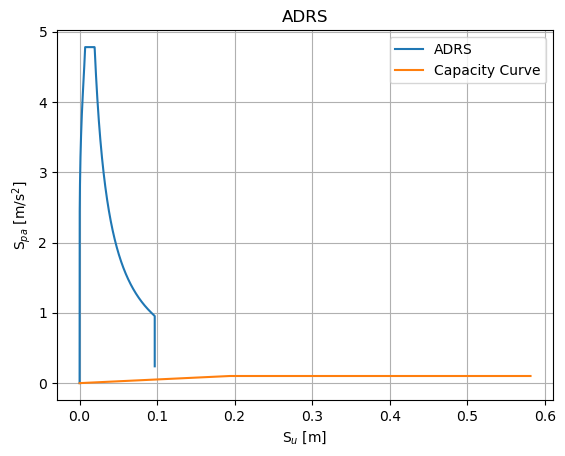

In [19]:
### NOTHING TO BE CHANGED
# Calculate the displacement parameters per Griffith et al. (2003)
Delta1 = d1*Delta_star           # [m]
Delta2 = d2*Delta_star           # [m]

# Write vectors for plotting
x = np.array([[0],[Delta1],[Delta2]])
y = np.array([[0],[a_star*(1-Delta1)/Delta_star],[a_star*(1-Delta1)/Delta_star]])

## Compute ADRS
# Initialize vectors
Qs = np.sum(m)*agr
T_vals = np.linspace(0,4,1000)
Su_vals = np.zeros((len(T_vals),1))
Se_vals = np.zeros((len(T_vals),1))
[S,Tb,Tc,Td] = spectrum_vals(soil_type)

for i in range(1,1000):
    omega = 2*np.pi/T_vals[i]                                           # natural frequency [rad/s]
    Se_vals[i] = RS(T_vals[i],agr,S,Tb,Tc,Td)                           # spectral acceleration [m/s^2]
    if T_vals[i] < Tc: 
        Ry = max(Se_vals[i]*m_star/Qs,1)                                # R relationship [-]
        wd_int = ((Ry-1)*Tc/T_vals[i] + 1)*Se_vals[i]/((omega**2)*Ry)   # displacement capacity [m]
        Su_vals[i] = min(wd_int,3*Se_vals[i]/omega**2)                  # spectral displacement capacity [m]
    else:
        Su_vals[i] = Se_vals[i]/(omega**2)                              # spectral displacement capacity [m]

## Plot capacity curve
# plot results
plt.figure()
plt.grid()
plt.plot(Su_vals,Se_vals,label='ADRS')
plt.plot(x,y,label='Capacity Curve')
plt.legend()
plt.xlabel('S$_u$ [m]')
plt.ylabel('S$_{pa}$ [m/s$^2$]')
plt.title('ADRS')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ec31d9b1-b904-46de-90ff-bc7ed068e5e5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>